# to understand mineral ppte/dissolution first need to undertsand Ksp (equilib)

for the dissolution equilibrium reaction of a solid (AB$_{(s)}$)

$$ \mathrm{AB}_{(\mathrm{s})} = \mathrm{A^{n+}} + \mathrm{B^{n-}}$$

$$K_{sp} = [\mathrm{A^{n+}}][\mathrm{B^{n-}}]$$

we can solve for precipitation or not and the amount if we compare the ion activity product  (IAP) to the $K_{sp}$ value.  IF IAP is is greater than Ksp then preciptiation will happen until the two are equal (IAP is the same mathematical from as $K_{sp}$ but IAP is not necessarily at equilibrium.

Let's do an example with 10 mM calcium and open system and increasing the pH.

$$ \mathrm{CaCO_3}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + \mathrm{CO_3^{2-}}$$

$$K_{sp} = [\mathrm{Ca^{2+}}][\mathrm{CO_3^{2-}}]=3.4e-9$$

ALSO for comparison calculate saturation index (IAP/$K_{sp}$) for portlandite.  If IAP>1 ppte would be predicted.

$$ \mathrm{Ca(OH)_2}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + 2\mathrm{OH^{-}}$$

$$K_{sp} = [\mathrm{Ca^{2+}}][\mathrm{OH^{-}}]^2=5.5e-6$$


In [122]:
% clear the space

clear

% input constants

KspC=3.4e-9; KspP=5.5e-6; PCO2=10^-3.5; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; Kw=1e-14;
pH=2:0.1:14; H=10.^-pH; OH=Kw./H; CaT=0.01; Ca=CaT;

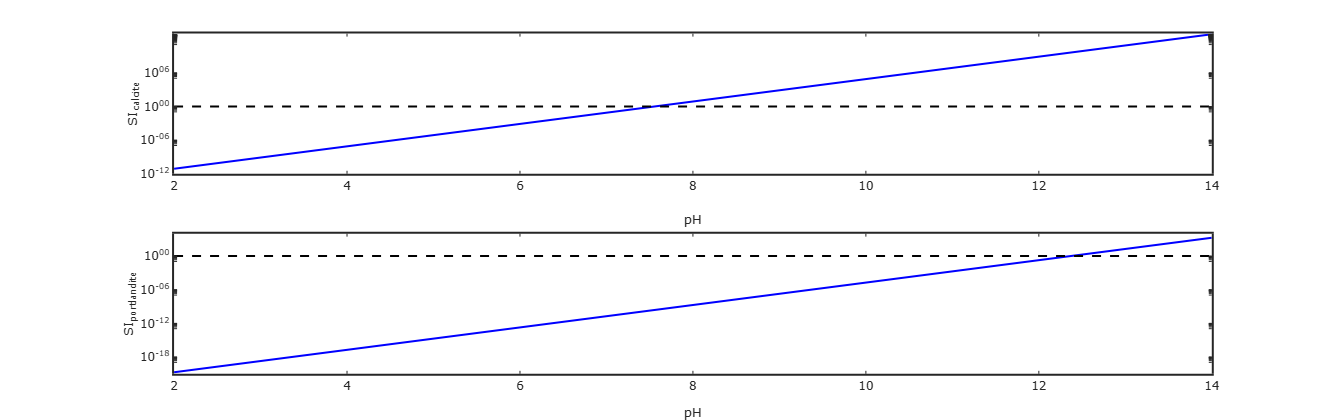

In [123]:
% run without allowing precipitation just to show what the SI looks like
graphics_toolkit ("plotly");

H2CO3=KH*PCO2*ones(size(pH)); HCO3=(Ka1.*H2CO3)./H; CO3=(Ka2.*HCO3)./H; 
IAPC=Ca.*CO3; SIC=IAPC./KspC; IAPP=Ca.*((OH).^2); SIP=IAPP./KspP;

subplot(211); semilogy(pH,SIC,'b-','linewidth',2); xlabel('pH'); ylabel('SI_{calcite}'); set(gca,'linewidth',2,'fontsize',12)
hold on; plot(pH,ones(size(pH)),'k--','linewidth',2)
yticks([10^-12 10^-6 10^0 10^6]); 

subplot(212); semilogy(pH,SIP,'b-','linewidth',2); xlabel('pH'); ylabel('SI_{portlandite}'); set(gca,'linewidth',2,'fontsize',12)
hold on; plot(pH,ones(size(pH)),'k--','linewidth',2)
yticks([10^-18 10^-12 10^-6 10^0]); 


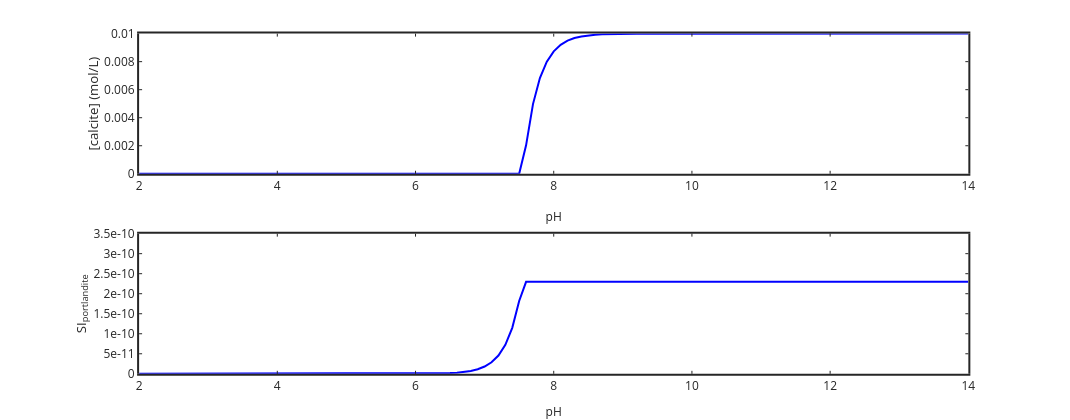

In [124]:
% now if SI>=1 ppte CaCO3

Ca=CaT*ones(size(pH)); Calcite=zeros(size(pH));

for i=1:length(pH)
    H(i)=10.^-pH(i); OH(i)=Kw/H(i); H2CO3(i)=KH*PCO2; HCO3(i)=(Ka1.*H2CO3(i))./H(i); CO3(i)=(Ka2.*HCO3(i))./H(i); 
    IAPC=Ca(i).*CO3(i); SIC(i)=IAPC./KspC; IAPP=Ca(i).*((OH(i)).^2); SIP(i)=IAPP./KspP;
    if SIC(i)>=1
        Ca(i)=KspC/CO3(i);
        Calcite(i)=CaT-Ca(i); 
        IAPP=Ca(i)*((OH(i)).^2); SIP(i)=IAPP./KspP;
    end
end

subplot(211); plot(pH,Calcite,'b-','linewidth',2)
set(gca,'linewidth',2,'fontsize',12)
xlabel('pH','fontsize',12); ylabel('[calcite] (mol/L)')

subplot(212); plot(pH,SIP,'b-','linewidth',2)
set(gca,'linewidth',2,'fontsize',12)
xlabel('pH','fontsize',12); ylabel('SI_{portlandite}')        
    

# you can see that calcite and portlandite are not possible at equilibrium together (at least not at normal pH, for open CO2 system)